<a href="https://colab.research.google.com/github/WAWQAQMAKABAKA/5243Project3_team6/blob/main/project3_a_b_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving result.csv to result (4).csv
=== Initial df shape: (544, 7)

=== summary_df preview ===
                         participant_id prompt_condition photo_present  \
0  00e83a7f-b11c-41d8-95a7-4aab8a1e0d17          Emotion         False   
1  00e83a7f-b11c-41d8-95a7-4aab8a1e0d17          Emotion          True   
2  00e83a7f-b11c-41d8-95a7-4aab8a1e0d17          Explain         False   
3  00e83a7f-b11c-41d8-95a7-4aab8a1e0d17          Explain          True   
4  0274c724-077e-4f08-b391-636b7cad7555          Emotion         False   
5  0274c724-077e-4f08-b391-636b7cad7555          Emotion          True   
6  0274c724-077e-4f08-b391-636b7cad7555          Explain         False   
7  0274c724-077e-4f08-b391-636b7cad7555          Explain          True   
8  1280a0d0-a38a-4e8a-b68b-b5c063582ed7          Emotion         False   
9  1280a0d0-a38a-4e8a-b68b-b5c063582ed7          Emotion          True   

   accuracy         rt  
0       NaN        NaN  
1       NaN        NaN  
2      0.75  34

<ipython-input-8-7714c66d2cbd>:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['participant_id','prompt_condition','photo_present'])
<ipython-input-8-7714c66d2cbd>:126: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


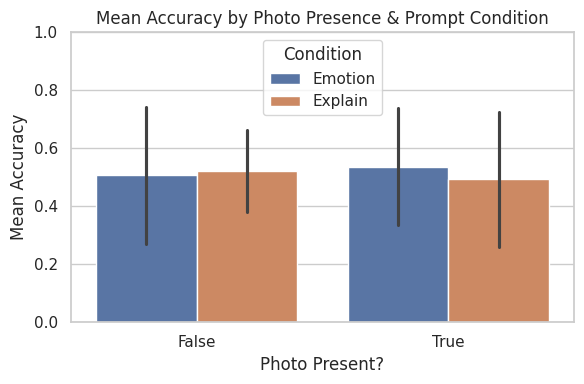

<ipython-input-8-7714c66d2cbd>:143: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


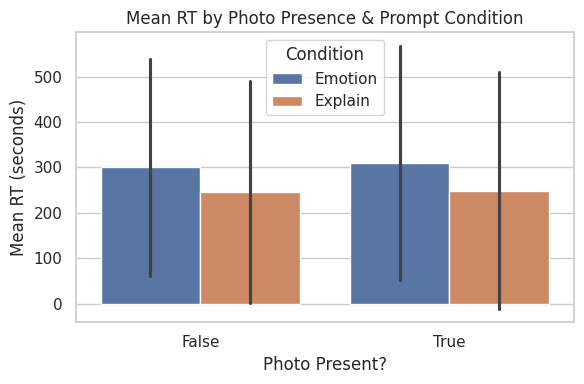


Analysis complete!


In [8]:
##################################################
# Mixed-Factor A/B Analysis (Manual Groupby Fix)
##################################################

from google.colab import files
uploaded = files.upload()  # Prompt to upload "result.csv"

import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load CSV
df = pd.read_csv('result.csv')
print("=== Initial df shape:", df.shape)

# 2. Rename columns
df = df.rename(columns={
    'id': 'participant_id',
    'explain/emotion': 'prompt_condition',
    'true/false': 'correct_label',
    'showing picture or not': 'photo_present',
    'user answer': 'user_answer',
    'user response': 'open_ended_response',
    'response time': 'rt'
})

# Convert booleans to strings, if needed
if pd.api.types.is_bool_dtype(df['correct_label']):
    df['correct_label'] = df['correct_label'].map({True: "TRUE", False: "FALSE"})
if pd.api.types.is_bool_dtype(df['photo_present']):
    df['photo_present'] = df['photo_present'].map({True: "True", False: "False"})
if pd.api.types.is_bool_dtype(df['user_answer']):
    df['user_answer'] = df['user_answer'].map({True: "true", False: "false"})

# Standardize
df['correct_label'] = df['correct_label'].astype(str).str.upper()
df['user_answer'] = df['user_answer'].astype(str).str.lower()

# 3. Create accuracy column
def is_correct(row):
    correct = row['correct_label']  # "TRUE"/"FALSE"
    user_ans_str = row['user_answer']
    if any(x in user_ans_str for x in ['true','yes','yeah']):
        user_bin = 'TRUE'
    elif any(x in user_ans_str for x in ['false','no','not','prob']):
        user_bin = 'FALSE'
    else:
        user_bin = 'FALSE'  # fallback
    return 1 if (user_bin == correct) else 0

df['accuracy'] = df.apply(is_correct, axis=1)

# 4. Convert columns to categories
df['prompt_condition'] = df['prompt_condition'].astype('category')
df['photo_present'] = df['photo_present'].astype('category')

# 5. Groupby (manual approach) for 'accuracy' and 'rt'
grouped = df.groupby(['participant_id','prompt_condition','photo_present'])

df_mean_acc = grouped['accuracy'].mean().rename('accuracy')
df_mean_rt = grouped['rt'].mean().rename('rt')

# Combine
summary_df = pd.concat([df_mean_acc, df_mean_rt], axis=1).reset_index()

print("\n=== summary_df preview ===")
print(summary_df.head(10))
print("summary_df shape:", summary_df.shape)

# 6. Mixed ANOVA for Accuracy
long_acc = summary_df.rename(columns={
    'participant_id': 'subject',
    'prompt_condition': 'between',
    'photo_present': 'within',
    'accuracy': 'dv'
}).copy()

anova_acc = pg.mixed_anova(
    data=long_acc,
    dv='dv',
    within='within',
    subject='subject',
    between='between'
)
print("\n=== Mixed ANOVA for Accuracy ===")
print(anova_acc)

# 7. Mixed ANOVA for RT
long_rt = summary_df.rename(columns={
    'participant_id': 'subject',
    'prompt_condition': 'between',
    'photo_present': 'within',
    'rt': 'dv'
}).copy()

anova_rt = pg.mixed_anova(
    data=long_rt,
    dv='dv',
    within='within',
    subject='subject',
    between='between'
)
print("\n=== Mixed ANOVA for Response Time ===")
print(anova_rt)

# 8. Optional Post-Hoc
posthoc_acc = pg.pairwise_tests(
    data=long_acc,
    dv='dv',
    between='between',
    within='within',
    subject='subject',
    parametric=True,
    padjust='bonf'
)
print("\n=== Post-hoc pairwise tests for Accuracy ===")
print(posthoc_acc)

# 9. Visuals
sns.set(style="whitegrid")

# Plot accuracy
plt.figure(figsize=(6,4))
sns.barplot(
    data=summary_df,
    x='photo_present',
    y='accuracy',
    hue='prompt_condition',
    ci='sd'
)
plt.ylim(0,1)
plt.title("Mean Accuracy by Photo Presence & Prompt Condition")
plt.xlabel("Photo Present?")
plt.ylabel("Mean Accuracy")
plt.legend(title="Condition")
plt.tight_layout()
plt.show()

# Plot RT
plt.figure(figsize=(6,4))
sns.barplot(
    data=summary_df,
    x='photo_present',
    y='rt',
    hue='prompt_condition',
    ci='sd'
)
plt.title("Mean RT by Photo Presence & Prompt Condition")
plt.xlabel("Photo Present?")
plt.ylabel("Mean RT (seconds)")
plt.legend(title="Condition")
plt.tight_layout()
plt.show()

print("\nAnalysis complete!")
